In [34]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow.keras as keras
import tensorflowjs as tfjs
import numpy as np
from PIL import Image
import time
import sys
import cProfile, pstats
import scipy.ndimage as nd
import functools
import importlib
from IPython.display import display,clear_output
stime = time.time()

In [57]:
model = keras.applications.resnet.ResNet50(
    include_top=True, weights='imagenet', classes=1000,
    classifier_activation='softmax')
shp = (1,)+model.input.shape[1:]

./deepdream/filter/ResNet50


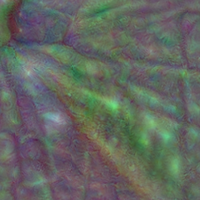

conv5_block3_3_conv/16


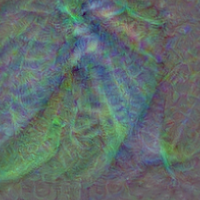

conv5_block3_2_conv/16


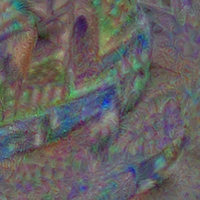

conv5_block3_1_conv/16


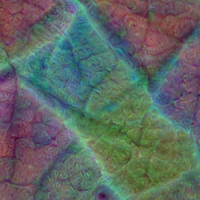

conv5_block2_3_conv/16


KeyboardInterrupt: 

In [74]:
import transforms
importlib.reload(transforms)

show_crop = 12

fromback=False
limitmag=False
one_batch=True
jitter =False
tjitternum = 4
total_variation =False
fixed_steps =True
blur =False
single = False
animate=False
skipdone = False

steps = 512


def _gaussian_kernel(kernel_size, sigma, n_channels):
    x = tf.range(-kernel_size // 2 + 1, kernel_size // 2 + 1, dtype=tf.float32)
    g = tf.math.exp(-(tf.pow(x, 2) / (2 * tf.pow(sigma, 2))))
    g_norm2d = tf.pow(tf.reduce_sum(g), 2)
    g_kernel = tf.tensordot(g, g, axes=0) / g_norm2d
    g_kernel = tf.expand_dims(g_kernel, axis=-1)
    return tf.expand_dims(tf.tile(g_kernel, (1, 1, n_channels)), axis=-1)

# gaussian_kernel = _gaussian_kernel(5, 3.0, 3)


lossdiffthreshold = 0.1
sval = 0.0 # only works if power of 2?
sval = 0.0 # only works if power of 2?
transform = transforms.compose([   
    transforms.pad(20, mode="constant", constant_value=100),
    transforms.random_scale([1 + i / 50.0 for i in range(-1,2)]),
    transforms.random_rotate(list(range(-1, 2)) + 2 * [0]),
    transforms.jitter(2),
    transforms.unpad(20)
  ])

# transform = transforms.compose([   
#     transforms.pad(12, mode="CONSTANT", constant_value=0.5),
#     transforms.jitter(3),
#     transforms.unpad(12),
#   ])

class Adam:
    def __init__(self, params, lr):
        self.lr = lr
        self.z = 1
    def step(self, params):
        return params
adam = tf.keras.optimizers.Adam(learning_rate=0.1)
def optneuron(model, layer, idx, num, single):
  new_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output])
  step_size = 3
  momentum = 0.5
  momentum_vector = tf.fill((num,)+shp[1:], 0.0)
  # img = tf.fill((num,)+shp[1:], sval)
  img = tf.fill((num,)+shp[1:],100.0)
  best_loss = -9999999999900.9
  best_loss_step = 0
  now_ldthresh = lossdiffthreshold
  regularization_amount = 11.0
  # gaussian_kernel = _gaussian_kernel(10,regularization_amount, 3)
  for step in range(steps):
    with tf.GradientTape() as tape:
      tape.watch(img)
      activation = new_model(img)
      lst = []
      for j in range(num):
        begin = [j,activation.shape[1]//2,activation.shape[2]//2,idx+j] if single else [j,0,0,idx+j]
        size = [1,1,1,1] if single else [1,-1,-1,1]
        lst.append(tf.slice(activation, begin=begin, size=size))
      loss = tf.math.reduce_sum(tf.math.add_n(lst))
      if total_variation:
        tv = tf.reduce_mean(tf.image.total_variation(img))
        loss-=tv*10000
      if limitmag:
        loss-=tf.math.reduce_mean(img*img)*4000
      # print(loss)
      gradient = tape.gradient(loss, img)
      gradient /= tf.math.reduce_std(gradient) + 1e-8
      momentum_vector = momentum*momentum_vector+step_size*gradient
      img += momentum_vector
#       adam.minimize(-loss,[img], tape=tape)
      img = tf.clip_by_value(img, 0,255)
      img = transform(img)
      if animate:
        pimg = Image.fromarray((img).numpy()[0].astype(np.uint8))
        clear_output()
        display(pimg)
      if blur:
        img = img.numpy()
        img = nd.filters.gaussian_filter(img, [0,regularization_amount,regularization_amount,0], order=0)
        img = tf.convert_to_tensor(img)
        if step>0 and step%10==0:
          # regularization_amount*=0.5
          gaussian_kernel = _gaussian_kernel(5, regularization_amount,3)
      if loss>best_loss+now_ldthresh:
        best_loss = loss
        best_loss_step = step
      elif not fixed_steps and step-best_loss_step>=20:
        print("stopped early after", step, "steps")
        break
  return img

def cropsval(batch):
  left = 0
  for i in range(shp[1]):
    if batch[0,i,batch.shape[2]//2, 0]!=sval:
      left = i
      break
  right = 0
  for i in range(shp[1]-1, -1,-1):
    if batch[0,i,batch.shape[2]//2, 0]!=sval:
      right = i
      break
  top = 0
  for i in range(shp[1]):
    if batch[0,batch.shape[2]//2,i, 0]!=sval:
      top = i
      break
  bottom = 0
  for i in range(shp[1]-1, -1,-1):
    if batch[0,batch.shape[2]//2,i, 0]!=sval:
      bottom = i
      break
  cropped = tf.slice(batch, [0, top, left, 0], [-1, bottom-top, right-left, -1])
  return cropped
  
    
spath = "./deepdream"
if not os.path.exists(spath):
  os.mkdir(spath)
spath+= "/single" if single else "/filter"
if not os.path.exists(spath):
  os.mkdir(spath)
  
mpath =spath+ '/'+'ResNet50'
if not os.path.exists(mpath):
  os.mkdir(mpath)

max_batch = 16 if one_batch else 96


def __main__():
  print(mpath)
  layers = reversed(list(model.layers)) if fromback else list(model.layers)
  for layer in layers:
    oldcrit = (layer.weights and layer.trainable and  layer.name[-2:]!='bn'and layer.name[:5]!='batch')
    addcrit = (layer.name[-3:] in ['add']) 
    if oldcrit and len(layer.output.shape)==4:
      lpath = mpath+"/"+layer.name
      if not os.path.exists(lpath):
        os.mkdir(lpath)
      elif skipdone:
        continue
      nfilters = layer.output.shape[-1]
      for start in range(0,nfilters, max_batch):
        num = min(nfilters, start+max_batch)-start
        img = optneuron(model, layer, start, num, single)
#         cropped = cropsval(img)
        cropped = tf.slice(img, [0,show_crop, show_crop, 0],[-1,img.shape[1]-show_crop*2, img.shape[2]-show_crop*2, -1])
        if cropped.shape[1]==0: 
          print("cropped size zero!")
          continue
        npy = (cropped).numpy().astype(np.uint8)
        for j in range(num):
          pilimg = Image.fromarray(npy[j])
          # pilimg.show()
          fname = lpath+"/"+str(j+start)+".png"
          if j==0: display(pilimg)
          try: # try catch so it doesn't fail if you had that image open in windows
            pilimg.save(fname)
          except:
            print("couldn't write", fname)
            pass
          # with open(fname, 'wb') as f:
        #   f.write(img.numpy().tobytes())  
        print(layer.name+"/"+str(start+num))
        if one_batch: break
__main__()